In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import pylab
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import os
import pydicom
from skimage import measure
from skimage.transform import resize
from tensorflow import keras
import keras
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import csv
from keras.callbacks import *
from os.path import isfile, join

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Store into lists train_val_list.txt and test_list.txt 

In [2]:
images_folder = "/notebooks/storage/data/images"
filenames = [f for f in os.listdir(images_folder) if isfile(join(images_folder, f))]
print("Total images in folder", len(filenames))

folder = "/storage/data/train_val_list.txt"
train_examples=0
f=open(folder,'r')
train_filenames = []
for line in f.readlines():
    train_examples+=1
    ll = line.replace('\n','')
    train_filenames.append(ll)
print("Traininng examples: ",train_examples)

folder2 = "/storage/data/test_list.txt"
test_examples=0
test_filenames = []
f=open(folder2,'r')
for line in f.readlines():
    test_examples+=1
    ll = line.replace('\n','')
    test_filenames.append(ll)
print("Test examples: ",test_examples)

test_filenames = test_filenames

total = train_examples + test_examples
print("Total examples: ", total)

print("distribution of training: ", train_examples/total * 100)
print("distribution of testing: ", test_examples/total * 100)

print("total filenames: ", len(train_filenames)+len(test_filenames))

Total images in folder 112120
Traininng examples:  86524
Test examples:  25596
Total examples:  112120
distribution of training:  77.17088833392793
distribution of testing:  22.829111666072066
total filenames:  112120


In [2]:
images_folder = "/notebooks/storage/data/images"
folder = "/storage/data/train_filenmaes.txt"
folder2 = "/storage/data/test_labels.txt"
folder3 = "/storage/data/validation_labels.txt"

validation = []
f=open(folder3,'r')
for line in f.readlines():
    validation.append(line)
    
validation = validation[9:]
validation_filenames = []
for p in validation:
    nn = p[0:16]
    validation_filenames.append(nn)

print(len(validation_filenames))

train = []
f=open(folder,'r')
for line in f.readlines():
    train.append(line)
    
train = train[9:]
train_filenames = []
for p in train:
    nn = p[0:16]
    train_filenames.append(nn)

print(len(train_filenames))


test = []
f=open(folder2,'r')
for line in f.readlines():
    test.append(line)
    
test = test[9:]
test_filenames = []
for p in test:
    nn = p[0:16]
    test_filenames.append(nn)

print(len(test_filenames))

11219
78468
22433


In [3]:
print(len(validation_filenames) + len(train_filenames) + len(test_filenames))

112120


## Parsed the Data_entry-2017.csv  into dictionaries

In [3]:
def parse_data(df):
    """
      parsed = {
        
        'image-name01': {
            'png': path/to/png/file,
            'label': list of labels, 
            'patient_gender': M or F
            'pattient_age': int
            'patientID':int
        },
        'image-name-02': {
            'png': path/to/png/file,
            'label': list of labels,
            'patient_gender': M or F
            'pattient_age': int
            'patientID':int
        }, ...

      }

    """
    parsed = {}
    for n, row in df.iterrows():
        pid = row['Image Index']
        if pid not in parsed:
            labels = row['Finding Labels']
            parsed[pid] = {
                'png': '%s' % pid,
                'label': labels.split("|"),
                'patient_gender': row['Patient Gender'],
                'pattient_age': row['Patient Age'],
                'patientID': row['Patient ID']}
    return parsed
  
df = pd.read_csv('/storage/data/Data_Entry_2017.csv')
parsed = parse_data(df)

def parsed_patient(parsed):
    """
      dic = {
        
        'patientID-01': {
            'png': ['image-name-01', 'image-name-02', 'image-name-03', ... ]
        },
        'patientID-02': {
            'png': ['image-name-05', 'image-name-06', ...]
        }, ...

      }
      
    """
    dic = {}
    for key,value in parsed.items():
        if value['patientID'] not in dic:
            dic[value['patientID']] = {
                'png': [key]
            }
        else:
            dic[value['patientID']]['png'].append(key)
    return dic

pat_dic = parsed_patient(parsed)


## Convert the disease labels into 14-dimensional binary vector

In [4]:
def concrete_labels(parsed, filenames):
    n_labels = 14
    labels_array = np.zeros((len(filenames), n_labels), dtype=int) #4999 x 14
    dictionary = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltration':3, 
                  'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7, 'Consolidation': 8,
                 'Edema':9, 'Emphysema':10, 'Fibrosis': 11, 'Pleural_Thickening': 12, 'Hernia': 13}
    i = 0
    for item in filenames:
        diseases = parsed[item]['label']
        for d in diseases:
            if d == 'No Finding':
                pass
            else:
                j = dictionary[d]
                labels_array[i][j] = 1
        i += 1
    return labels_array

def get_label(filename, parsed):
    n_labels = 14
    label_array = np.zeros((1, n_labels), dtype=int) #1 x 14
    dictionary = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltration':3, 
                  'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7, 'Consolidation': 8,
                 'Edema':9, 'Emphysema':10, 'Fibrosis': 11, 'Pleural_Thickening': 12, 'Hernia': 13}
    diseases = parsed[filename]['label']
    for d in diseases:
        if d == 'No Finding':
            pass
        else:
            j = dictionary[d]
            label_array[0][j] = 1
    return label_array

yy = get_label('00000003_005.png', parsed)
print(yy[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1]


## Initial parameters

In [5]:
LR = 0.001
EPOCHS = 10
BATCHSIZE = 16
IMAGE_SIZE = 224
MOMENTUM = 0.9
DIMS = (IMAGE_SIZE,IMAGE_SIZE,3)

## Data Generator

In [6]:
class generator(keras.utils.Sequence):
    
    def __init__(self, state, folder, filenames, parsed, batch_size=BATCHSIZE, 
                 image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.state = state
        self.filenames = filenames
        self.parsed = parsed
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def __load__(self, filename):
      
        # load png file as numpy array
        img_path = os.path.join(self.folder, filename)
        img = Image.open(img_path).convert("RGB")
        img_arr = np.asarray(img)
        img_arr = img_arr / 255.  
        img_arr = resize(img_arr, (self.image_size, self.image_size), mode='reflect')
        mean = np.array([0.485, 0.456, 0.406 ])
        std = np.array([0.229, 0.224, 0.225 ])
        img_arr = img_arr - mean
        img_arr = img_arr / std
        
        #horizontal flip
        if self.augment and self.state % 2 == 0:
            img_arr = np.fliplr(img_arr)
            self.state += 1
        #label of img
        label = get_label(filename, self.parsed)[0]
        return img_arr, label
      
    def __loadpredict__(self, filename):
        # load png file as numpy array
        img_path = os.path.join(self.folder, filename)
        img = Image.open(img_path).convert("RGB")
        img_arr = np.asarray(img)
        img_arr = img_arr / 255.  
        img_arr = resize(img_arr, (self.image_size, self.image_size), mode='reflect')
        mean = np.array([0.485, 0.456, 0.406 ])
        std = np.array([0.229, 0.224, 0.225 ])
        img_arr = img_arr - mean
        img_arr = img_arr / std
        
        return img_arr
      
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files for test generaator to predict
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs
        else:
            items = [self.__load__(filename) for filename in filenames]
            imgs, labels = zip(*items)
            imgs = np.array(imgs)
            labels = np.array(labels)
            return imgs, labels
    
    def on_epoch_end(self,):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(224, 224, 3)


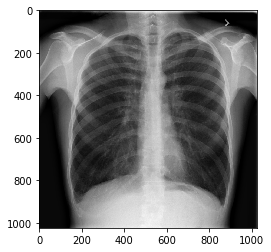

In [7]:
from PIL import Image, ImageFile
import matplotlib.image as mpimg

img_path = os.path.join(images_folder, train_filenames[90])
img = Image.open(img_path).convert("RGB")
img_arr = np.asarray(img)
img_arr = img_arr.astype(np.float32)
img_arr = img_arr / 255.
imgplot = plt.imshow(img_arr)

img_arr = resize(img_arr, (224,224), mode='reflect')

mean = np.array([0.485, 0.456, 0.406 ])
std = np.array([0.229, 0.224, 0.225 ])
img_arr = img_arr - mean
img_arr = img_arr / std

#imgplot = plt.imshow(img_arr)
print(img_arr.shape)

img_arr = np.fliplr(img_arr)
#imgplot = plt.imshow(img_arr)

In [32]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape=DIMS, weights='imagenet', include_top = False, pooling = 'avg')

# add a global spatial average pooling layer
x = base_model.output
#x = keras.layers.BatchNormalization(momentum = MOMENTUM)(x)
# and a logistic layer -- let's say we have 2 classes
x = Dense(14, activation='linear')(x)
predictions = Dense(14, activation='sigmoid')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 149, 149, 32) 96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_6 (

In [22]:
from keras.applications.xception import Xception

base_model = Xception(input_shape=DIMS, weights='imagenet', include_top = False, pooling = 'avg')

# add a global spatial average pooling layer
x = base_model.output
#x = keras.layers.BatchNormalization(momentum = MOMENTUM)(x)
# and a logistic layer -- let's say we have 2 classes
x = Dense(14, activation='linear')(x)
predictions = Dense(14, activation='sigmoid')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## Create model

In [8]:
from keras.applications.densenet import DenseNet201

base_model = DenseNet201(input_shape=DIMS, weights='imagenet', include_top = False)

# add a global spatial average pooling layer
x = base_model.output
#x = keras.layers.BatchNormalization(momentum = MOMENTUM)(x)
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 2 classes
x = Dense(14, activation='linear')(x)
predictions = Dense(14, activation='sigmoid')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [8]:
from keras.applications.densenet import DenseNet169

base_model = DenseNet169(input_shape=DIMS, weights='imagenet', include_top = False)

# add a global spatial average pooling layer
x = base_model.output
#x = keras.layers.BatchNormalization(momentum = MOMENTUM)(x)
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 2 classes
x = Dense(14, activation='linear')(x)
predictions = Dense(14, activation='sigmoid')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [9]:
# unweighted loss function
def unweighted_binary_crossentropy(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred))

In [10]:
model.load_weights("/storage/weights.03-35.29.hdf5")
model.compile(optimizer=keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999),
              loss=unweighted_binary_crossentropy, metrics=['accuracy'])
print("Loaded model from disk")



Loaded model from disk


In [ ]:
state = 0
ImageFile.LOAD_TRUNCATED_IMAGES = True
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=0.000001)
model.compile(optimizer=keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999),
              loss=unweighted_binary_crossentropy, metrics=['accuracy'])
train_gen = generator(state, images_folder, train_filenames, parsed, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(state, images_folder, validation_filenames, parsed, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

checkpoint_path="/storage/weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

history1 = model.fit_generator(train_gen, validation_data=valid_gen, 
                              epochs=EPOCHS, shuffle=True, verbose=1, callbacks=[checkpoint, reduce_lr])

# serialize model to JSON
model_json = model.to_json()
with open("/storage/model_16_01_linear.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/storage/model_16_01_linear.h5")
print("Saved model to disk")

Epoch 1/10


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


4904/4904 [==============================] - 5633s 1s/step - loss: 39.9126 - acc: 0.1668 - val_loss: 37.9684 - val_acc: 0.1586

Epoch 00001: saving model to /storage/weights.01-37.97.hdf5
Epoch 2/10
4904/4904 [==============================] - 5916s 1s/step - loss: 37.7291 - acc: 0.2015 - val_loss: 42.9161 - val_acc: 0.1846

Epoch 00002: saving model to /storage/weights.02-42.92.hdf5
Epoch 3/10
4904/4904 [==============================] - 5735s 1s/step - loss: 36.0038 - acc: 0.2315 - val_loss: 35.2936 - val_acc: 0.2447

Epoch 00003: saving model to /storage/weights.03-35.29.hdf5
Epoch 4/10
4904/4904 [==============================] - 5352s 1s/step - loss: 35.4810 - acc: 0.2476 - val_loss: 36.7204 - val_acc: 0.2260

Epoch 00004: saving model to /storage/weights.04-36.72.hdf5
Epoch 5/10
4904/4904 [==============================] - 6202s 1s/step - loss: 35.0820 - acc: 0.2501 - val_loss: 40.4867 - val_acc: 0.2528

Epoch 00005: saving model to /storage/weights.05-40.49.hdf5
Epoch 6/10
4904/

Epoch 1/10


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


4904/4904 [==============================] - 5041s 1s/step - loss: 34.2072 - acc: 0.2603 - val_loss: 34.9410 - val_acc: 0.1938

Epoch 00001: saving model to /storage/weights.01-34.94.hdf5
Epoch 2/10
4904/4904 [==============================] - 5234s 1s/step - loss: 33.7994 - acc: 0.2637 - val_loss: 34.4480 - val_acc: 0.2148

Epoch 00002: saving model to /storage/weights.02-34.45.hdf5
Epoch 3/10
4904/4904 [==============================] - 4809s 981ms/step - loss: 33.3963 - acc: 0.2648 - val_loss: 34.7255 - val_acc: 0.2644

Epoch 00003: saving model to /storage/weights.03-34.73.hdf5
Epoch 4/10
2815/4904 [================>.............] - ETA: 30:36 - loss: 32.1279 - acc: 0.2824

## Results using the new filenames setup, AUC = 0.78, 6 epochs, lowest loss 34.57

Epoch 1/10


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


4904/4904 [==============================] - 5431s 1s/step - loss: 40.1542 - acc: 0.1891 - val_loss: 38.9677 - val_acc: 0.1387

Epoch 00001: saving model to /storage/weights.01-38.97.hdf5
Epoch 2/10
4904/4904 [==============================] - 5449s 1s/step - loss: 38.3830 - acc: 0.2029 - val_loss: 38.6404 - val_acc: 0.1797

Epoch 00002: saving model to /storage/weights.02-38.64.hdf5
Epoch 3/10
4904/4904 [==============================] - 5344s 1s/step - loss: 36.8475 - acc: 0.2285 - val_loss: 36.2171 - val_acc: 0.3258

Epoch 00003: saving model to /storage/weights.03-36.22.hdf5
Epoch 4/10
4904/4904 [==============================] - 5308s 1s/step - loss: 35.8685 - acc: 0.2440 - val_loss: 36.0433 - val_acc: 0.2208

Epoch 00004: saving model to /storage/weights.04-36.04.hdf5
Epoch 5/10
4904/4904 [==============================] - 5351s 1s/step - loss: 35.1919 - acc: 0.2509 - val_loss: 35.2359 - val_acc: 0.2348

Epoch 00005: saving model to /storage/weights.05-35.24.hdf5
Epoch 6/10
4402/

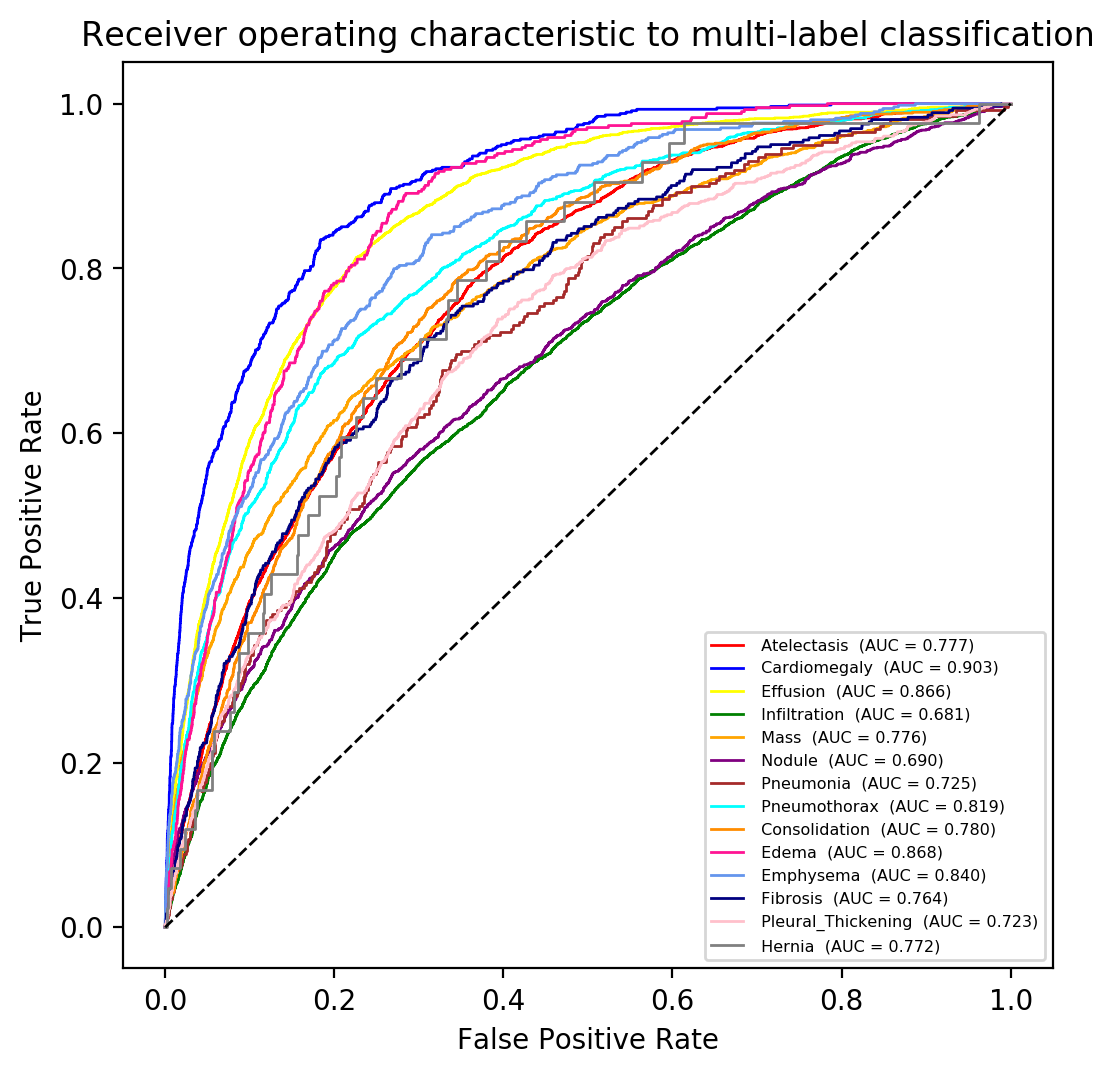

In [16]:
AVERAGE AUC SCORE:  0.7846517168325375

## CheXNet with lr decay of 0.1 when validation loss plateaus and no random horizontal flipping

Epoch 1/20


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


4902/4902 [==============================] - 4513s 921ms/step - loss: 34.6563 - acc: 0.1685 - val_loss: 43.2046 - val_acc: 0.2584

Epoch 00001: saving model to /storage/weights/weights.01-43.20.hdf5
Epoch 2/20
4902/4902 [==============================] - 5486s 1s/step - loss: 32.6680 - acc: 0.2183 - val_loss: 39.2497 - val_acc: 0.2213

Epoch 00002: saving model to /storage/weights/weights.02-39.25.hdf5
Epoch 3/20
4902/4902 [==============================] - 4801s 979ms/step - loss: 31.6276 - acc: 0.2457 - val_loss: 39.9674 - val_acc: 0.2349

Epoch 00003: saving model to /storage/weights/weights.03-39.97.hdf5
Epoch 4/20
4902/4902 [==============================] - 4098s 836ms/step - loss: 30.2509 - acc: 0.2581 - val_loss: 37.1355 - val_acc: 0.3031

Epoch 00004: saving model to /storage/weights/weights.04-37.14.hdf5
Epoch 5/20
4902/4902 [==============================] - 4380s 893ms/step - loss: 29.8458 - acc: 0.2696 - val_loss: 37.1936 - val_acc: 0.3254

Epoch 00005: saving model to /st

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4902/4902 [==============================] - 4756s 970ms/step - loss: 29.4789 - acc: 0.2748 - val_loss: 36.9905 - val_acc: 0.3098

Epoch 00006: saving model to /storage/weights/weights.06-36.99.hdf5
Epoch 7/20
4902/4902 [==============================] - 4153s 847ms/step - loss: 29.4189 - acc: 0.2733 - val_loss: 37.0061 - val_acc: 0.3150

Epoch 00007: saving model to /storage/weights/weights.07-37.01.hdf5
Epoch 8/20
4901/4902 [============================>.] - ETA: 0s - loss: 29.3638 - acc: 0.2738

## Import model and weights

In [13]:
from keras.models import model_from_json

# load json and create model
#json_file = open('/storage/model_16_01_linear.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/storage/weights.05-33.59.hdf5")
print("Loaded model from disk")

model.compile(optimizer=keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999),
              loss=unweighted_binary_crossentropy, metrics=['accuracy'])
print("Compile model from disk")

Loaded model from disk
Compile model from disk


## Predict probabilities for testing data

In [11]:
state = 0
test_generator = generator(state, images_folder, test_filenames, parsed, batch_size=BATCHSIZE, 
                           image_size=IMAGE_SIZE, shuffle=False, augment=False, predict=True)

In [ ]:
predict = model.predict_generator(test_generator, verbose = 1)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1377/1403 [============================>.] - ETA: 26s

In [27]:
# create labels for the testing data
test_labels = concrete_labels(parsed, test_filenames[0:25601])

## AUC score - ROC curve for one label

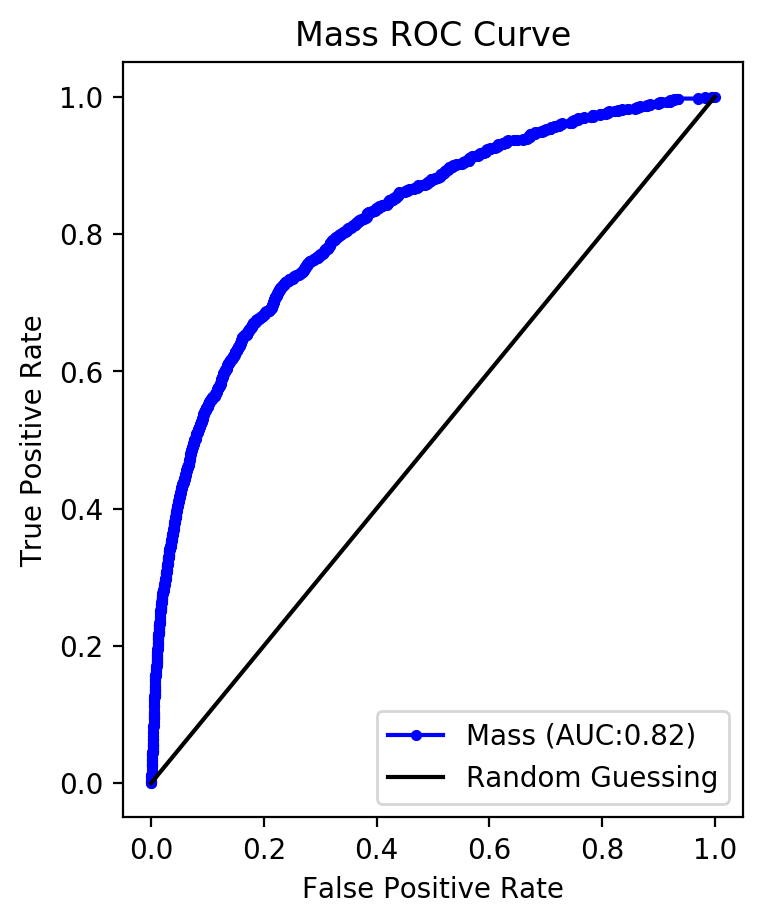

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_labels[:,4], predict[:,4])
fig, ax1 = plt.subplots(1,1, figsize = (4, 5), dpi = 200)
ax1.plot(fpr, tpr, 'b.-', label = 'Mass (AUC:%2.2f)' % roc_auc_score(test_labels[:,4], predict[:,4]))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Mass ROC Curve')
fig.savefig('roc_valid.pdf')

## AUC score - ROC curve for all labels

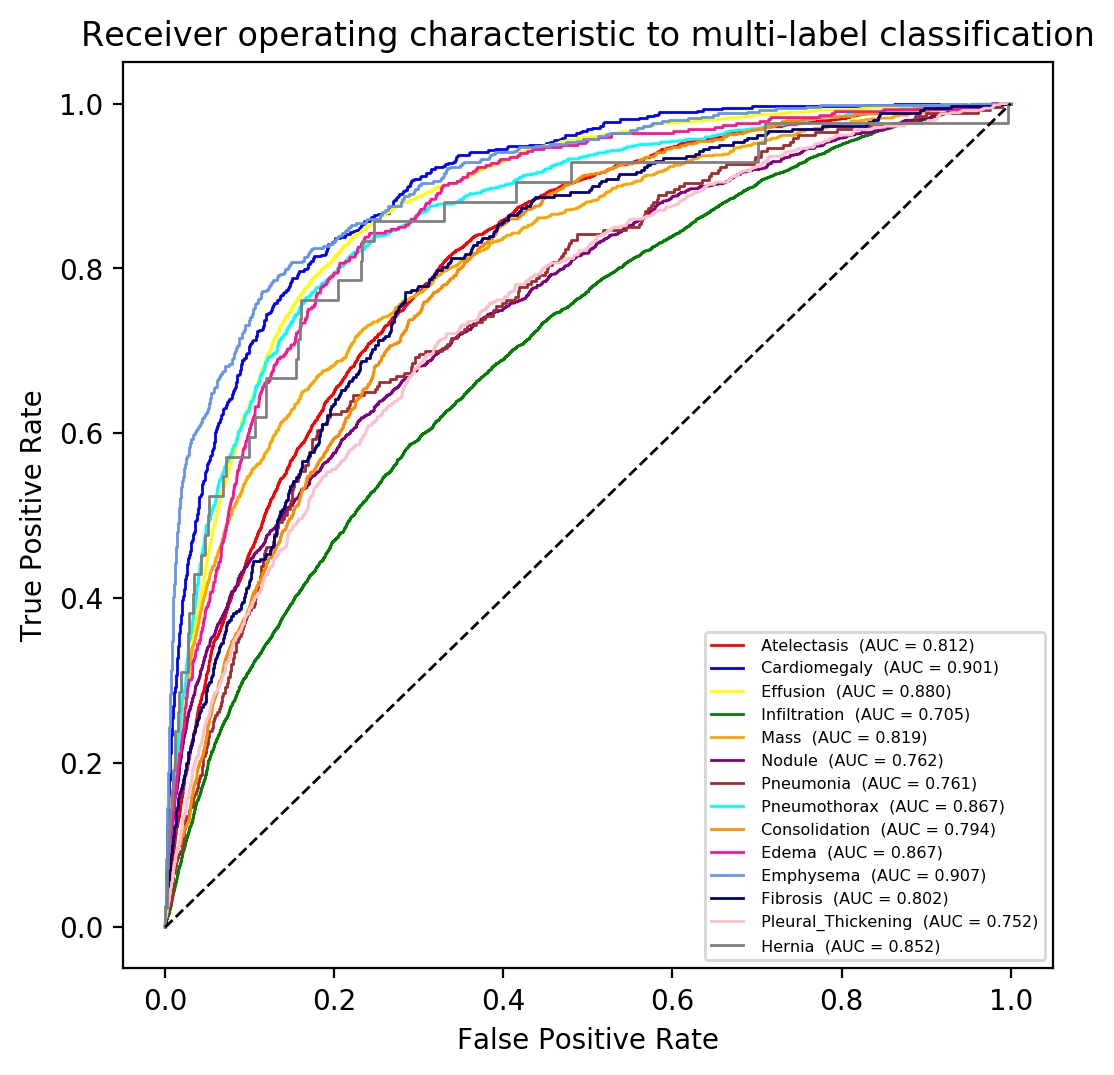

In [31]:
from itertools import cycle
from matplotlib.pyplot import figure

figure(num=None, figsize=(6, 6), dpi=200, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots(num=None, figsize = (6, 6), dpi = 200)
lw = 1
average_auc_score = 0

labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
              'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
              'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

colors = cycle(['red','blue','yellow','green', 'orange','purple','brown','aqua','darkorange','deeppink','cornflowerblue','navy', 'pink', 'grey' ])
for i, color in zip(range(14), colors):
    fpr, tpr, _ = roc_curve(test_labels[:,i], predict[:,i])
    average_auc_score += roc_auc_score(test_labels[:,i], predict[:,i])
    ax1.plot(fpr, tpr, color=color, lw=lw,
             label=' {0}  (AUC = {1:0.3f})'
             ''.format(labels[i], roc_auc_score(test_labels[:,i], predict[:,i])))

ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver operating characteristic to multi-label classification')
ax1.legend(loc="lower right",fontsize="xx-small")
#ax1.show()
fig.savefig('densenet169.pdf')

In [30]:
print("AVERAGE AUC SCORE: ", average_auc_score/14)

AVERAGE AUC SCORE:  0.8198867030499424


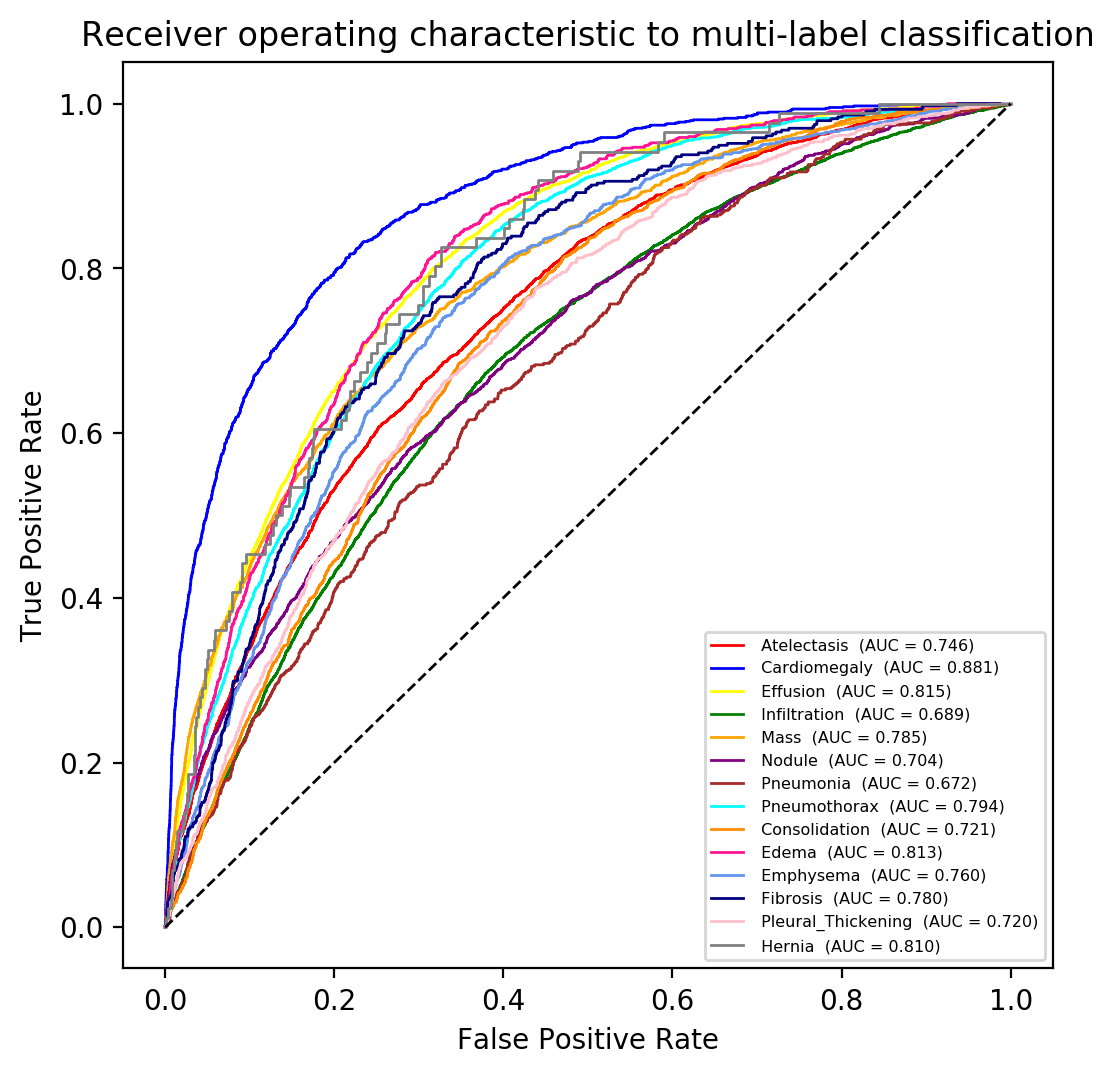

In [21]:
#################10 epochs, lowest validation loss, Lr decrease when validation loss plateaus

In [20]:
print("AVERAGE AUC SCORE: ", average_auc_score/14)

AVERAGE AUC SCORE:  0.7636955994873544


In [1]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index
#ax.tick_params(axis='x', colors='black')
#ax.tick_params(axis='y', colors='black')
#ax.set_facecolor((1,1,1))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history1' is not defined

# Observations

- running model for 10 epochs using a learning rate decay at after each opoch and choosing the model with the lowest validation loss gives a average AUC of 0.764, no much of an improvement